## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [3]:
from pathlib import Path

_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
archive = keras.utils.get_file(origin=_URL, extract=True)
data_dir = Path(archive).with_suffix('')

68606236/68606236 [==============================] - 0s 0us/step


In [11]:
for img in list(data_dir.glob('train/dogs/*'))[:32]:
    print(plt.imread(img).shape)

(374, 500, 3)
(333, 500, 3)
(371, 400, 3)
(499, 500, 3)
(261, 350, 3)
(300, 399, 3)
(333, 499, 3)
(357, 370, 3)
(343, 208, 3)
(353, 499, 3)
(346, 308, 3)
(335, 448, 3)
(192, 200, 3)
(374, 500, 3)
(375, 499, 3)
(499, 443, 3)
(374, 500, 3)
(375, 499, 3)
(368, 457, 3)
(331, 500, 3)
(374, 499, 3)
(499, 500, 3)
(500, 316, 3)
(231, 404, 3)
(375, 499, 3)
(345, 288, 3)
(385, 250, 3)
(374, 500, 3)
(100, 99, 3)
(499, 358, 3)
(500, 471, 3)
(332, 500, 3)


In [48]:
image_height = 128
image_width = 128
batch_size = 64
num_classes = 2

In [18]:
def preprocessVGG(image, label = None) -> tuple:
    image = tf.image.resize(image, size=[image_height, image_width])
    image = keras.applications.vgg19.preprocess_input(image)
    return (image, label)

def preprocess(image, label = None) -> tuple:
    image = tf.image.resize(image, size=[image_height, image_width])
    image = keras.layers.Rescaling(scale=1./255)(image)
    return (image, label)

(([], []), ([], []))

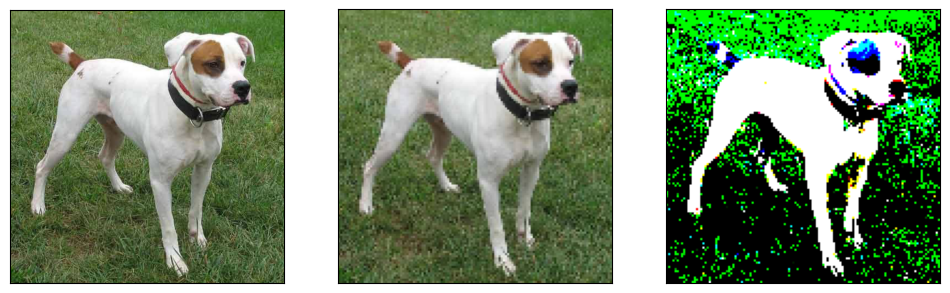

In [25]:
sample_img = plt.imread(list(data_dir.glob('train/dogs/*'))[3])

plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(preprocess(sample_img)[0])
plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(preprocessVGG(sample_img)[0])
plt.xticks([]), plt.yticks([])

## Generate & augmentate

In [26]:
class GetGenerator:
    def __init__(self, imsize: tuple):
        self.image_height, self.image_width = imsize[0], imsize[1]
        self.autotune = tf.data.AUTOTUNE

    def preprocess(self, image, label) -> tuple:
        image = tf.image.resize(image, size=[self.image_height, self.image_width])
        image = keras.applications.vgg19.preprocess_input(image)
        return (image, label)

    def configuration(self, ds):
        ds = ds.map(self.preprocess)
        ds = ds.cache()
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.prefetch(buffer_size=self.autotune)
        return ds
    
    def generator(self, dir) -> dict:
        print('[TRAIN]')
        train_ds = keras.utils.image_dataset_from_directory(
            dir / 'train', 
            image_size=(self.image_height, self.image_width), 
            batch_size=batch_size,  
            validation_split=0.1, 
            subset='training', 
            seed=10
        )

        print('\n[VALID]')
        val_ds = keras.utils.image_dataset_from_directory(
            dir / 'train',         
            image_size=(self.image_height, self.image_width), 
            batch_size=batch_size, 
            validation_split=0.1, 
            subset='validation', 
            seed=10
        )

        print('\n[TEST]')
        test_ds = keras.utils.image_dataset_from_directory(
            dir / 'validation', 
            image_size=(self.image_height, self.image_width), 
            batch_size=batch_size, 
            shuffle=False
        )

        class_names = train_ds.class_names

        train_ds = self.configuration(train_ds)
        val_ds = self.configuration(val_ds)

        return {'train': train_ds, 'valid': val_ds, 'test': test_ds, 'classes': class_names}

In [27]:
obj = GetGenerator([image_height, image_width])
ds = obj.generator(data_dir)

[TRAIN]
Found 2000 files belonging to 2 classes.
Using 1800 files for training.

[VALID]
Found 2000 files belonging to 2 classes.
Using 200 files for validation.

[TEST]
Found 1000 files belonging to 2 classes.


In [28]:
ds['train']

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Classification & Localization (weak)

In [31]:
vgg19.trainable = False
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [87]:
class FCN(keras.Model):
    def __init__(self, name: str = None, **kwargs):
        super(FCN, self).__init__(**kwargs)

        layers, augmentation_layers = [], []
        BN = keras.layers.BatchNormalization

        augmentation_layers.append(keras.layers.RandomFlip('horizontal', input_shape=(image_height, image_width, 3)))
        augmentation_layers.append(keras.layers.RandomRotation(0.1))
        augmentation_layers.append(keras.layers.RandomZoom(0.1))

        layers.append(keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))

        layers.append(BN())
        layers.append(keras.layers.UpSampling2D(size=2))
        
        layers.append(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))

        layers.append(BN())
        layers.append(keras.layers.UpSampling2D(size=2))

        layers.append(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))

        layers.append(BN())
        layers.append(keras.layers.UpSampling2D(size=2))

        layers.append(keras.layers.Conv2D(filters=128, kernel_size=5, activation='relu', padding='same'))

        layers.append(BN())
        layers.append(keras.layers.Dropout(rate=0.2))
        layers.append(keras.layers.UpSampling2D(size=2))

        layers.append(keras.layers.Conv2D(filters=128, kernel_size=5, activation='relu', padding='same'))

        layers.append(BN())
        layers.append(keras.layers.Dropout(rate=0.1))
        layers.append(keras.layers.UpSampling2D(size=2))

        layers.append(keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same'))
        layers.append(keras.layers.Conv2D(
            filters=num_classes, 
            kernel_size=1
            )
        )

        layers.append(keras.layers.GlobalAveragePooling2D())
        layers.append(keras.layers.Activation('softmax'))

        self.seq_layers = layers
        self.aug_layers = augmentation_layers

    def call(self, x: tf.Tensor) -> tf.Tensor:
        augmentation_layers = self.aug_layers

        for layer in augmentation_layers:
            x = layer(x)

        x = vgg19(x, training=False)

        for layer in self.seq_layers:
            x = layer(x)
        
        return x
    
    def model(self, shape: tuple = None):
        x = keras.layers.Input(shape=(shape[0], shape[1], 3), batch_size=batch_size)
        return keras.Model(inputs=[x], outputs=self.call(x))
    
    def predict_heatmaps(self, inputs):
        x = vgg19(inputs, training=False)
        for layer in self.seq_layers[:-2]:
            x = layer(x)

        return x

In [89]:
modelFCN = FCN()

if __name__ == '__main__':
    modelFCN.model(shape=(image_height, image_width)).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(64, 128, 128, 3)]       0         
                                                                 
 random_flip_8 (RandomFlip)  (64, 128, 128, 3)         0         
                                                                 
 random_rotation_8 (RandomRo  (64, 128, 128, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_8 (RandomZoom)  (64, 128, 128, 3)         0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 conv2d_25 (Conv2D)          (64, 4, 4, 512)           2359808   
                                                           

In [81]:
epochs = 10
class_map = {0: ds['classes'][0], 1: ds['classes'][1]}
class_map

{0: 'cats', 1: 'dogs'}

In [90]:
s = epochs * ds['train'].cardinality()
learning_rate = keras.optimizers.schedules.ExponentialDecay(1e-3, s, 1e-4)

opt = keras.optimizers.Nadam(learning_rate=learning_rate)
loss = keras.losses.SparseCategoricalCrossentropy()
metric = keras.metrics.SparseCategoricalAccuracy()

modelFCN.compile(optimizer=opt, loss=loss, metrics=metric)

In [91]:
historyFCN = modelFCN.fit(ds['train'], epochs=epochs, validation_data=ds['valid'])

Epoch 1/10
29/29 [==============================] - 22s 542ms/step - loss: 0.3524 - sparse_categorical_accuracy: 0.8750 - val_loss: 3.5767 - val_sparse_categorical_accuracy: 0.9200
Epoch 2/10
29/29 [==============================] - 16s 535ms/step - loss: 0.1536 - sparse_categorical_accuracy: 0.9283 - val_loss: 0.6820 - val_sparse_categorical_accuracy: 0.9450
Epoch 3/10
29/29 [==============================] - 15s 533ms/step - loss: 0.1206 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.3508 - val_sparse_categorical_accuracy: 0.9500
Epoch 4/10
29/29 [==============================] - 16s 537ms/step - loss: 0.1026 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.2462 - val_sparse_categorical_accuracy: 0.9550
Epoch 5/10
29/29 [==============================] - 16s 535ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.1691 - val_sparse_categorical_accuracy: 0.9550
Epoch 6/10
29/29 [==============================] - 16s 549ms/step - loss: 0.1005 - sparse_cate

## Predictions

In [92]:
modelFCN.evaluate(ds['test'])

16/16 [==============================] - 3s 167ms/step - loss: 0.2792 - sparse_categorical_accuracy: 0.9120


[0.2791786193847656, 0.9120000004768372]

In [125]:
def plot_results(image, trueLabel = None):
    heatmaps = modelFCN.predict_heatmaps(image[None, ...])
    predictions = tf.nn.softmax(keras.layers.GlobalAveragePooling2D()(heatmaps))
    predict = int(tf.argmax(predictions, axis=1).numpy())

    print('It is a "%s" with a probability of %s' % (class_map[predict], predictions[0][predict].numpy()))

    trueLabel = trueLabel.numpy() if trueLabel is tf.Tensor else trueLabel

    pred_heatmaps = tf.nn.softmax(heatmaps, axis=3)

    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(image/255.0)
    plt.title('True: [%s]' % trueLabel) 
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(heatmaps[0][..., trueLabel])
    plt.title('Predict: %s' % [predict])
    plt.xticks([]), plt.yticks([])

In [95]:
test_data = ds['test'].unbatch()

test_samples = list(test_data.map(lambda x, y: x))
test_labels = list(test_data.map(lambda x, y: y))

It is a "dogs" with a probability of 0.7453694


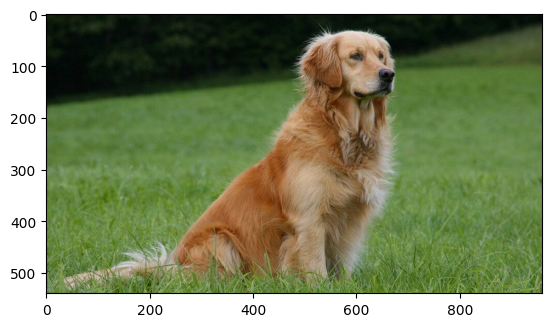

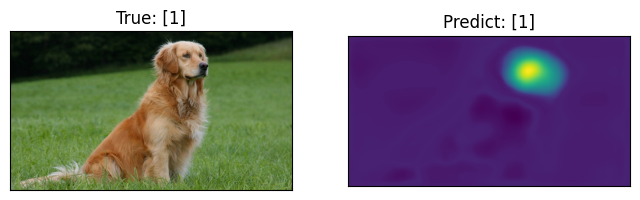

In [146]:
path_sample1 = '/content/drive/MyDrive/dogongrass.jpg'
sample_img1 = plt.imread(path_sample1)
plt.imshow(sample_img1)
plot_results(sample_img1, 1)

It is a "cats" with a probability of 0.89799255


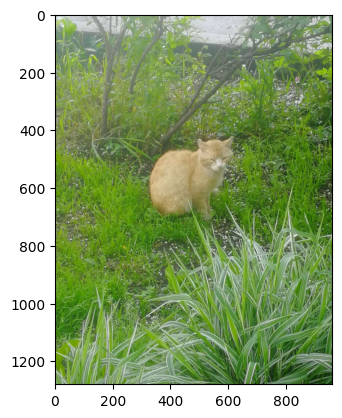

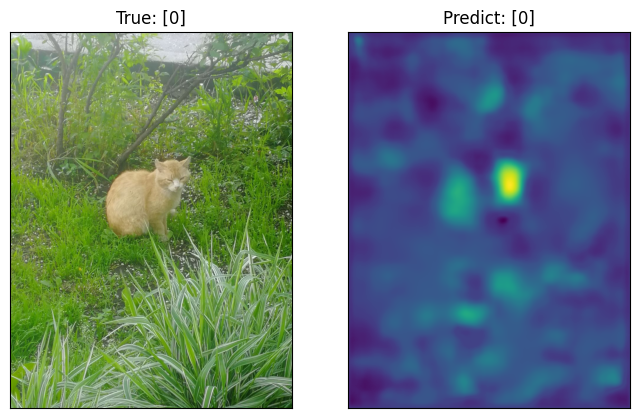

In [147]:
path_sample2 = '/content/drive/MyDrive/catongrass.jpg'
sample_img2 = plt.imread(path_sample2)
plt.imshow(sample_img2)
plot_results(sample_img2, 0)

It is a "cats" with a probability of 0.94581413


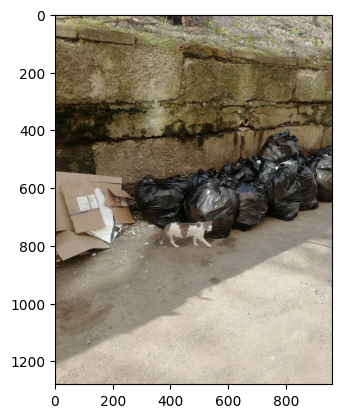

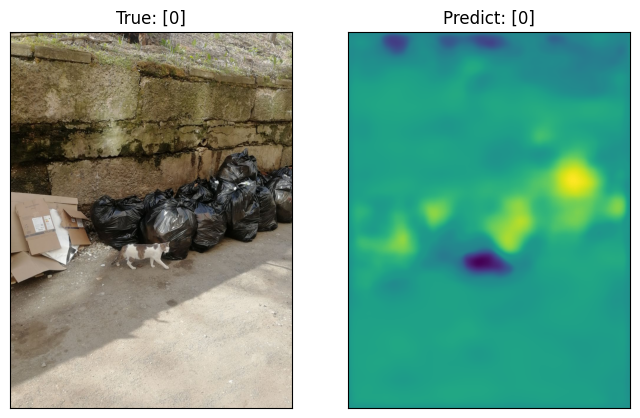

In [148]:
path_sample3 = '/content/drive/MyDrive/catontrash.jpg'
sample_img3 = plt.imread(path_sample3)
plt.imshow(sample_img3)
plot_results(sample_img3, 0)